**Electricity Data**
---

In [ ]:
!pip install frouros

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 844.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from frouros.datasets.real import Elec2
from frouros.detectors.concept_drift import DDM, DDMConfig

In [ ]:
elec2 = Elec2()
elec2.download()
data = elec2.load()
data

array([(0.    , b'2', 0.      , 0.056443, 0.439155, 0.003467, 0.422915, 0.414912, b'UP'),
       (0.    , b'2', 0.021277, 0.051699, 0.415055, 0.003467, 0.422915, 0.414912, b'UP'),
       (0.    , b'2', 0.042553, 0.051489, 0.385004, 0.003467, 0.422915, 0.414912, b'UP'),
       ...,
       (0.9158, b'7', 0.957447, 0.043593, 0.34097 , 0.002983, 0.247799, 0.362281, b'DOWN'),
       (0.9158, b'7', 0.978723, 0.066651, 0.329366, 0.00463 , 0.345417, 0.206579, b'UP'),
       (0.9158, b'7', 1.      , 0.050679, 0.288753, 0.003542, 0.355256, 0.23114 , b'DOWN')],
      dtype=[('date', '<f8'), ('day', 'S1'), ('period', '<f8'), ('nswprice', '<f8'), ('nswdemand', '<f8'), ('vicprice', '<f8'), ('vicdemand', '<f8'), ('transfer', '<f8'), ('class', 'S4')])

In [ ]:
X = np.array(data[["nswprice", "vicprice", "transfer","vicdemand"]].tolist())
y = np.array(data[["class"]].tolist()).astype("str")

In [ ]:
# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(X, columns=["nswprice", "vicprice", "transfer","vicdemand"])
df["class"] = y

df.shape

(45312, 5)

In [ ]:
df.to_csv("Electricity.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


# === Split features and target ===
X = df[["nswprice", "vicprice", "transfer", "vicdemand"]]
y = df["class"]

# === Encode labels ===
le = LabelEncoder()
y = le.fit_transform(y)

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === Scale features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Simple Neural Network ===
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu',
                      solver='adam', max_iter=300, random_state=42)

# === Train ===
model.fit(X_train, y_train)

# === Predict ===
y_pred = model.predict(X_test)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[6677 1136]
 [1999 3782]]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
cm=classification_report(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      7813
           1       0.77      0.65      0.71      5781

    accuracy                           0.77     13594
   macro avg       0.77      0.75      0.76     13594
weighted avg       0.77      0.77      0.77     13594



**Drift Injection**
---

In [ ]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "Electricity.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("har_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("ele_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("ele_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("ele_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

In [ ]:
import pandas as pd

# Load the datasets
df_sudden_type1 = pd.read_csv("/content/ele_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/ele_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("ele_recurrent_drift.csv")
df_nodrift      = pd.read_csv("har_no_drift.csv")

# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"

# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("har_all_drifts.csv", index=False)

print("Merged dataset saved to 'har_all_drifts.csv'")

Merged dataset saved to 'har_all_drifts.csv'


In [ ]:
df_sudden_type1

,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type
0,0.0,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1
1,1.0,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1
2,2.0,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1
3,3.0,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1
4,4.0,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1
...,...,...,...,...,...,...,...
45307,45307.0,0.044224,0.003033,0.405263,0.255049,DOWN,sudden_type1
45308,45308.0,0.044884,0.003072,0.420614,0.241326,DOWN,sudden_type1
45309,45309.0,0.043593,0.002983,0.362281,0.247799,DOWN,sudden_type1
45310,45310.0,0.066651,0.004630,0.206579,0.345417,UP,sudden_type1


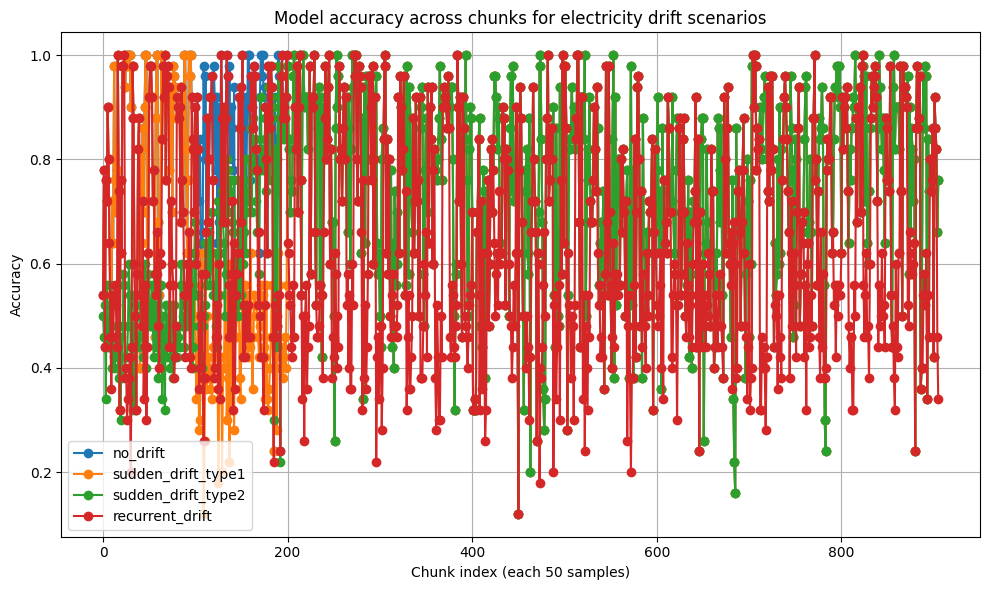

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(X, columns=["nswprice", "vicprice", "transfer","vicdemand"])
df["class"] = y


# ===================================================
# assume these dataframes already exist:
# df_nodrift, df_sudden_type1, df_sudden_type2, df_recurrent
# ===================================================
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

features = ["nswprice", "vicprice", "transfer", "vicdemand"]

target = "class"
chunk_size = 50

# ===================================================
# load main electricity dataset and train model
# ===================================================
X = df[features].values
y = LabelEncoder().fit_transform(df[target].values)

scaler = StandardScaler()
X_train = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=42)

model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu',
                      solver='adam', max_iter=300, random_state=42)
model.fit(X_train, y_train)

# ===================================================
# Evaluate trained model on each drift dataset
# ===================================================
plt.figure(figsize=(10, 6))

for name, df_mod in datasets.items():
    X_mod = df_mod[features].values
    y_mod = LabelEncoder().fit_transform(df_mod[target].values)

    # scale using same scaler from training
    X_mod_scaled = scaler.transform(X_mod)

    # predict
    y_pred = model.predict(X_mod_scaled)

    # chunk-wise accuracy
    n_samples = len(X_mod_scaled)
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        y_true_chunk = y_mod[start:end]
        y_pred_chunk = y_pred[start:end]
        if len(y_true_chunk) == 0:
            continue
        accs.append(accuracy_score(y_true_chunk, y_pred_chunk))

    plt.plot(range(len(accs)), accs, marker='o', label=name)

# ===================================================
# Plot results
# ===================================================
plt.title("Model accuracy across chunks for electricity drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# === Load your dataset (e.g., df_sudden_type1 or df) ===
# For example:
# df = df_sudden_type1
# or, if you are directly using elec.csv:
df = df_sudden_type1

# === Split features and target ===
features = ["nswprice", "vicprice", "transfer", "vicdemand"]
target = "class"

X = df[features]
y = df[target]

# === Encode labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

# === Scale features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Simple Neural Network ===
model = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

# === Train ===
model.fit(X_train_scaled, y_train)

# === Predict ===
y_pred = model.predict(X_test_scaled)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# === Combine features + true label + predicted label ===
df_results = X_test.copy()
df_results["true_class"] = le.inverse_transform(y_test)
df_results["predicted_class"] = le.inverse_transform(y_pred)

# === Save results ===
df_results.to_csv("predictions_with_features.csv", index=False)
print("\nPredictions saved to: predictions_with_features.csv")

# === Preview ===
print("\nSample predictions:")
print(df_results.head())

Confusion Matrix:
[[6418 1348]
 [2281 3547]]

Predictions saved to: predictions_with_features.csv

Sample predictions:
       nswprice  vicprice  transfer  vicdemand true_class predicted_class
26939  0.046025  0.003043  0.556140   0.373641         UP            DOWN
8321  -0.187299  0.003467  0.414912   0.422915       DOWN              UP
43379  0.043953  0.002985  0.364035   0.527965       DOWN            DOWN
27688  0.024919  0.001676  0.457895   0.320818       DOWN            DOWN
42648  0.049418  0.003199  0.748684   0.305541       DOWN            DOWN


Surrogate accuracy vs. black-box predictions: 0.9594


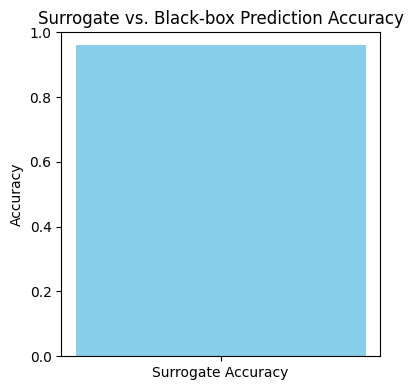

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# =======================================================
# === SURROGATE MODEL (Decision Tree for explainability)
# =======================================================
X_surrogate = df_results[features].values
# Use numeric labels (since DecisionTreeClassifier requires numeric targets)
y_surrogate = LabelEncoder().fit_transform(df_results["predicted_class"])

# Train surrogate (simple interpretable model)
surrogate_model = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate_model.fit(X_surrogate, y_surrogate)

# Evaluate surrogate fidelity
y_surrogate_pred = surrogate_model.predict(X_surrogate)
acc = accuracy_score(y_surrogate, y_surrogate_pred)
print(f"Surrogate accuracy vs. black-box predictions: {acc:.4f}")

# =======================================================
# === PLOT 1: Surrogate fidelity bar
# =======================================================
plt.figure(figsize=(4, 4))
plt.bar(['Surrogate Accuracy'], [acc], color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Surrogate vs. Black-box Prediction Accuracy')
plt.tight_layout()
plt.show()

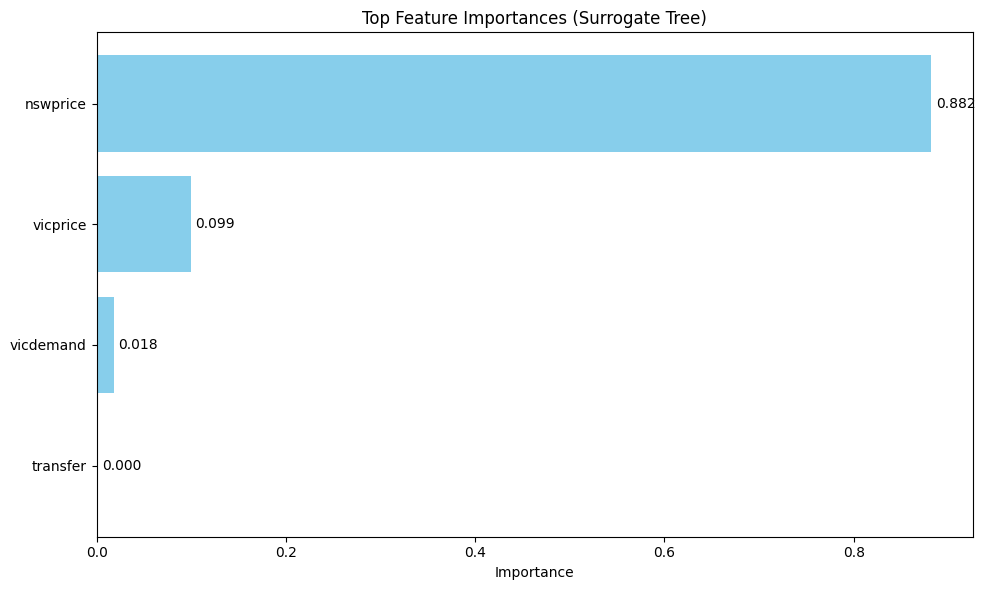

In [ ]:
# =======================================================
# === PLOT 2: Top Feature Importances from surrogate
# =======================================================
importances = surrogate_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending
top_n = min(10, len(features))
top_indices = indices[:top_n]
top_features = [features[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(top_n), top_importances[::-1], color='skyblue')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Importance')
plt.title('Top Feature Importances (Surrogate Tree)')

# Add numerical values to bars
for i, b in enumerate(bars):
    width = b.get_width()
    plt.text(width + 0.005, b.get_y() + b.get_height()/2,
             f"{top_importances[::-1][i]:.3f}", va='center')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# === Get feature importances from the trained surrogate model ===
importances = surrogate_model.feature_importances_

# === Build DataFrame of all features with their importances ===
df_baseline_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# === Sort in descending order ===
df_baseline_importance = df_baseline_importance.sort_values(
    by='importance', ascending=False
).reset_index(drop=True)

# === Select top 10 features ===
df_baseline_top10 = df_baseline_importance.head(10)

# === Display top 10 ===
print(df_baseline_top10)


     feature  importance
0   nswprice    0.882115
1   vicprice    0.099470
2  vicdemand    0.018073
3   transfer    0.000341


**Base Statistics**
---

In [ ]:
import pandas as pd

# --- Configuration ---
block_size = 50  # Number of samples per block
selected_cols = ['nswprice', 'vicprice', 'transfer', 'vicdemand']

# Make a copy of the electricity dataset
df_tmp = df.copy()
df_tmp['block'] = df_tmp.index // block_size  # Assign block index

# Check if all columns exist
cols_to_use = [c for c in selected_cols if c in df_tmp.columns]
if len(cols_to_use) < len(selected_cols):
    print("Warning: some selected columns missing and skipped")

# Compute mean, variance, and standard deviation per block
df_baseline_stats = (
    df_tmp
    .groupby('block')[cols_to_use]
    .agg(['mean', 'var', 'std'])
)

# Flatten MultiIndex column names (e.g., nswprice_mean, vicprice_var, etc.)
df_baseline_stats.columns = [
    f"{col}_{stat}" for col, stat in df_baseline_stats.columns
]

# Reset index so 'block' becomes a column
df_baseline_stats = df_baseline_stats.reset_index()

# Save to CSV
df_baseline_stats.to_csv("electricity_baseline_stats.csv", index=False)

# Display the resulting DataFrame

df_baseline_stats

,block,nswprice_mean,nswprice_var,nswprice_std,vicprice_mean,vicprice_var,vicprice_std,transfer_mean,transfer_var,transfer_std,vicdemand_mean,vicdemand_var,vicdemand_std
0,0,0.045187,0.000032,0.005635,0.003467,0.000000e+00,0.000000,0.414912,0.000000,0.000000,0.422915,0.000000,0.000000
1,1,0.044180,0.000029,0.005397,0.003467,0.000000e+00,0.000000,0.414912,0.000000,0.000000,0.422915,0.000000,0.000000
2,2,0.050325,0.000132,0.011475,0.003467,0.000000e+00,0.000000,0.414912,0.000000,0.000000,0.422915,0.000000,0.000000
3,3,0.090800,0.001610,0.040122,0.003467,0.000000e+00,0.000000,0.414912,0.000000,0.000000,0.422915,0.000000,0.000000
4,4,0.059353,0.000174,0.013179,0.003467,0.000000e+00,0.000000,0.414912,0.000000,0.000000,0.422915,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,902,0.070450,0.000442,0.021032,0.004845,2.308807e-06,0.001519,0.359956,0.012730,0.112828,0.495422,0.021622,0.147044
903,903,0.076251,0.000583,0.024138,0.005218,2.830901e-06,0.001683,0.358561,0.008885,0.094262,0.503392,0.018114,0.134589
904,904,0.076635,0.000398,0.019938,0.005157,1.809652e-06,0.001345,0.421307,0.006631,0.081434,0.459876,0.011442,0.106968
905,905,0.061619,0.000154,0.012409,0.004241,7.590072e-07,0.000871,0.362930,0.006226,0.078902,0.331481,0.003967,0.062981


**New Data Statictsics**
---

In [ ]:
import pandas as pd

# --- Configuration ---
block_size = 50  # samples per block
selected_cols = ['nswprice', 'vicprice', 'transfer', 'vicdemand']

# --- Combine all drift datasets into one ---
df_all = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent],
    axis=0,
    ignore_index=True
)

# --- Assign block IDs ---
df_all['block'] = df_all.index // block_size

# --- Filter only available columns ---
cols_to_use = [c for c in selected_cols if c in df_all.columns]
if len(cols_to_use) < len(selected_cols):
    print("⚠️ Warning: some selected columns missing and skipped")

# --- Compute mean/variance/std for each block ---
df_all_stats = (
    df_all
    .groupby('block')[cols_to_use]
    .agg(['mean', 'var', 'std'])
)

# --- Flatten multi-level column names ---
df_all_stats.columns = [f"{col}_{stat}" for col, stat in df_all_stats.columns]

# --- Reset index so 'block' becomes a column ---
df_all_stats = df_all_stats.reset_index()

# --- Save results ---
df_all_stats.to_csv("electricity_all_drift_stats.csv", index=False)
print("✅ Combined drift statistics saved to electricity_all_drift_stats.csv")

# --- Display preview of computed statistics ---
df_all_stats.head()


✅ Combined drift statistics saved to electricity_all_drift_stats.csv


,block,nswprice_mean,nswprice_var,nswprice_std,vicprice_mean,vicprice_var,vicprice_std,transfer_mean,transfer_var,transfer_std,vicdemand_mean,vicdemand_var,vicdemand_std
0,0,0.045187,0.000032,0.005635,0.003467,0.0,0.0,0.414912,0.0,0.0,0.422915,0.0,0.0
1,1,0.044180,0.000029,0.005397,0.003467,0.0,0.0,0.414912,0.0,0.0,0.422915,0.0,0.0
2,2,0.050325,0.000132,0.011475,0.003467,0.0,0.0,0.414912,0.0,0.0,0.422915,0.0,0.0
3,3,0.090800,0.001610,0.040122,0.003467,0.0,0.0,0.414912,0.0,0.0,0.422915,0.0,0.0
4,4,0.059353,0.000174,0.013179,0.003467,0.0,0.0,0.414912,0.0,0.0,0.422915,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np

df_baseline = pd.read_csv("electricity_baseline_stats.csv")
df_drift = pd.read_csv("electricity_all_drift_stats.csv")

# Drop accidental index columns
df_baseline = df_baseline.loc[:, ~df_baseline.columns.str.contains(r"^Unnamed")]
df_drift    = df_drift.loc[:, ~df_drift.columns.str.contains(r"^Unnamed")]

# Use only columns common to both files (excluding block)
common_cols = sorted(set(df_baseline.columns).intersection(df_drift.columns) - {"block"})

# Identify base feature names from columns like: base_mean, base_var, base_std
base_features = sorted({
    c.rsplit("_", 1)[0]
    for c in common_cols
    if c.rsplit("_", 1)[1] in ("mean", "var", "std")
})

def mu_var_from_row(row, base):
    """Extract (mu, var) for a base feature from a row with fallbacks."""
    mu  = row.get(f"{base}_mean", np.nan)
    var = row.get(f"{base}_var", np.nan)

    # fallback: var from std^2
    if pd.isna(var):
        std = row.get(f"{base}_std", np.nan)
        if not pd.isna(std):
            var = float(std) ** 2

    # enforce non-negative variance if present
    if not pd.isna(var):
        var = max(float(var), 0.0)

    return (float(mu) if not pd.isna(mu) else np.nan,
            float(var) if not pd.isna(var) else np.nan)

# ---- Build baseline distribution parameters ----
baseline_row = df_baseline[["block"] + common_cols].mean(numeric_only=True)

mu_b = np.array([mu_var_from_row(baseline_row, base)[0] for base in base_features], dtype=float)
v_b  = np.array([mu_var_from_row(baseline_row, base)[1] for base in base_features], dtype=float)

# ---- FDDS (same formula as your code) but KEEP per-feature values like before ----
out = []
for i, r in df_drift.iterrows():
    block_id = r["block"] if "block" in df_drift.columns else i

    mu_w = np.array([mu_var_from_row(r, base)[0] for base in base_features], dtype=float)
    v_w  = np.array([mu_var_from_row(r, base)[1] for base in base_features], dtype=float)

    row_out = {"block": block_id}

    # Per-feature mean and cov contributions
    per_feat_mean = (mu_b - mu_w) ** 2
    per_feat_cov  = (v_b + v_w - 2 * np.sqrt(v_b * v_w))

    # NaN handling exactly aligned with your masking idea:
    # if either side missing, that feature contribution becomes NaN
    per_feat_mean[np.isnan(mu_b) | np.isnan(mu_w)] = np.nan
    per_feat_cov[np.isnan(v_b)  | np.isnan(v_w)]  = np.nan

    # Store per-feature FDDS contributions (and optional component columns)
    for j, base in enumerate(base_features):
        row_out[f"{base}__mean"] = per_feat_mean[j]
        row_out[f"{base}__cov"]  = per_feat_cov[j]

        # exact per-feature contribution to FDDS
        if np.isnan(per_feat_mean[j]) or np.isnan(per_feat_cov[j]):
            row_out[base] = np.nan
        else:
            row_out[base] = float(per_feat_mean[j] + per_feat_cov[j])

    # Final scalar FDDS = sum across available features (ignore NaNs)
    contribs = np.array([row_out[base] for base in base_features], dtype=float)
    row_out["FDDS"] = float(np.nansum(contribs)) if np.any(~np.isnan(contribs)) else np.nan

    out.append(row_out)

df_fdds_vector = pd.DataFrame(out).sort_values("block").reset_index(drop=True)

# Preview
df_fdds_vector


,block,nswprice__mean,nswprice__cov,nswprice,transfer__mean,transfer__cov,transfer,vicdemand__mean,vicdemand__cov,vicdemand,vicprice__mean,vicprice__cov,vicprice,FDDS
0,0.0,0.000012,0.001696,0.001708,0.007308,0.008642,0.015950,1.124653e-08,0.007625,0.007625,4.286619e-14,0.000095,0.000095,0.025377
1,1.0,0.000020,0.001716,0.001736,0.007308,0.008642,0.015950,1.124653e-08,0.007625,0.007625,4.286619e-14,0.000095,0.000095,0.025405
2,2.0,0.000003,0.001249,0.001252,0.007308,0.008642,0.015950,1.124653e-08,0.007625,0.007625,4.286619e-14,0.000095,0.000095,0.024921
3,3.0,0.001776,0.000045,0.001821,0.007308,0.008642,0.015950,1.124653e-08,0.007625,0.007625,4.286619e-14,0.000095,0.000095,0.025490
4,4.0,0.000114,0.001132,0.001246,0.007308,0.008642,0.015950,1.124653e-08,0.007625,0.007625,4.286619e-14,0.000095,0.000095,0.024915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2714,2714.0,0.000294,0.000940,0.001235,0.014271,0.000164,0.014435,1.293386e-03,0.000789,0.002082,1.006557e-06,0.000074,0.000075,0.017827
2715,2715.0,0.000447,0.000544,0.000991,0.019157,0.000247,0.019404,6.935757e-03,0.005405,0.012341,1.854752e-06,0.000064,0.000066,0.032802
2716,2716.0,0.000564,0.002679,0.003243,0.000430,0.090252,0.090682,1.109967e-01,0.449807,0.560804,2.358983e-05,0.000019,0.000043,0.654772
2717,2717.0,0.007894,0.003372,0.011266,0.125900,0.218721,0.344621,2.699017e-01,0.389712,0.659614,5.582711e-05,0.000004,0.000060,1.015560


In [ ]:
import pandas as pd
import numpy as np

def compute_frechet_vector(
    baseline_stats_csv: str,
    drift_stats_csv: str,
    out_csv: str,
    block_col: str = "block",
):
    # ============================================================
    # Load baseline and drifted block statistics
    # ============================================================
    df_baseline = pd.read_csv(baseline_stats_csv)
    df_drifted  = pd.read_csv(drift_stats_csv)

    # ============================================================
    # Baseline reference vector: mean across all baseline blocks
    # (same as your code)
    # ============================================================
    baseline_row = df_baseline.mean(numeric_only=True)

    # ============================================================
    # Collect columns except 'block'
    # ============================================================
    cols = [c for c in df_baseline.columns if c != block_col]

    # Identify base features by stripping last suffix (mean/std/var/etc.)
    base_features = sorted(set(col.rsplit("_", 1)[0] for col in cols))

    records = []

    # Helper: get std from either *_std or sqrt(|*_var|)
    def get_std(row_like, base_name: str):
        std_val = row_like.get(f"{base_name}_std", np.nan)
        if pd.notna(std_val):
            return float(std_val)

        var_val = row_like.get(f"{base_name}_var", np.nan)
        if pd.notna(var_val):
            return float(np.sqrt(abs(var_val)))

        # If neither exists
        return np.nan

    # ============================================================
    # Compute Fréchet-like distances block-wise
    # ============================================================
    for idx, drift_row in df_drifted.iterrows():
        block_id = drift_row.get(block_col, idx)
        row_result = {block_col: block_id}

        for base in base_features:
            # baseline mean/std
            mean_b = float(baseline_row.get(f"{base}_mean", np.nan))
            std_b  = get_std(baseline_row, base)

            # drift mean/std (current block)
            mean_n = float(drift_row.get(f"{base}_mean", np.nan))
            std_n  = get_std(drift_row, base)

            # If any part missing, keep NaN (prevents fake distances)
            if np.isnan(mean_b) or np.isnan(std_b) or np.isnan(mean_n) or np.isnan(std_n):
                row_result[base] = np.nan
            else:
                # Same 1D Fréchet-like distance you used
                row_result[base] = np.sqrt((mean_b - mean_n) ** 2 + (std_b - std_n) ** 2)

        records.append(row_result)

    df_frechet_vector = pd.DataFrame(records)
    df_frechet_vector.to_csv(out_csv, index=False)

    print(f"✅ Fréchet distance vector saved to {out_csv}")
    print(df_frechet_vector.head())
    return df_frechet_vector


# ============================================================
# APPLY TO YOUR ELECTRICITY FILES (same as your current run)
# ============================================================
df_frechet_vector = compute_frechet_vector(
    baseline_stats_csv="electricity_baseline_stats.csv",
    drift_stats_csv="electricity_all_drift_stats.csv",
    out_csv="electricity_frechet_vector.csv",
)

✅ Fréchet distance vector saved to electricity_frechet_vector.csv
   block  nswprice  transfer  vicdemand  vicprice
0    0.0  0.023229  0.109635   0.066267  0.001307
1    1.0  0.023634  0.109635   0.066267  0.001307
2    2.0  0.017209  0.109635   0.066267  0.001307
3    3.0  0.043690  0.109635   0.066267  0.001307
4    4.0  0.018771  0.109635   0.066267  0.001307


In [ ]:


df_fdds_ele=pd.read_csv("electricity_frechet_vector.csv")
df_fdds_ele

,block,nswprice,transfer,vicdemand,vicprice
0,0.0,0.023229,0.109635,0.066267,0.001307
1,1.0,0.023634,0.109635,0.066267,0.001307
2,2.0,0.017209,0.109635,0.066267,0.001307
3,3.0,0.043690,0.109635,0.066267,0.001307
4,4.0,0.018771,0.109635,0.066267,0.001307
...,...,...,...,...,...
2714,2714.0,0.021193,0.125093,0.060896,0.001020
2715,2715.0,0.021750,0.144079,0.126012,0.001421
2716,2716.0,0.073892,0.325400,0.767779,0.006304
2717,2717.0,0.117103,0.606596,0.828457,0.009803


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# Load pre-computed statistics for electricity dataset
# ============================================================
df_baseline = pd.read_csv("electricity_baseline_stats.csv")
df_drifted = pd.read_csv("electricity_all_drift_stats.csv")

# ============================================================
# Baseline reference vector: mean across all baseline blocks
# ============================================================
baseline_row = df_baseline.mean()

# ============================================================
# Collect all columns except 'block'
# ============================================================
cols = [c for c in df_baseline.columns if c != 'block']

# Identify base features (remove suffix like _mean/_var/_std)
base_features = sorted(set(col.rsplit('_', 1)[0] for col in cols))

records = []

# ============================================================
# Compute Fréchet-like distances block-wise
# ============================================================
for idx, drift_row in df_drifted.iterrows():
    block_id = drift_row.get("block", idx)
    row_result = {"block": block_id}

    for base in base_features:
        # Extract baseline mean and std
        mean_b = float(baseline_row.get(f"{base}_mean", np.nan))
        std_b = float(baseline_row.get(f"{base}_std", np.sqrt(abs(baseline_row.get(f"{base}_var", 0)))))

        # Extract drifted mean and std for current block
        mean_n = float(drift_row.get(f"{base}_mean", np.nan))
        std_n = float(drift_row.get(f"{base}_std", np.sqrt(abs(drift_row.get(f"{base}_var", 0)))))

        # Fréchet distance in 1D (between baseline & drift block)
        d = np.sqrt((mean_b - mean_n)**2 + (std_b - std_n)**2)
        row_result[base] = d

    records.append(row_result)

# ============================================================
# Build DataFrame of Fréchet distances
# ============================================================
df_frechet_vector = pd.DataFrame(records)

# ============================================================
# Save results
# ============================================================
df_frechet_vector.to_csv("electricity_frechet_vector.csv", index=False)
print("✅ Fréchet distance vector saved to electricity_frechet_vector.csv")

# Preview
print(df_frechet_vector.head())

✅ Fréchet distance vector saved to electricity_frechet_vector.csv
   block  nswprice  transfer  vicdemand  vicprice
0    0.0  0.023229  0.109635   0.066267  0.001307
1    1.0  0.023634  0.109635   0.066267  0.001307
2    2.0  0.017209  0.109635   0.066267  0.001307
3    3.0  0.043690  0.109635   0.066267  0.001307
4    4.0  0.018771  0.109635   0.066267  0.001307


In [ ]:
df_baseline_top10

,feature,importance
0,nswprice,0.882115
1,vicprice,0.099470
2,vicdemand,0.018073
3,transfer,0.000341


In [ ]:
import pandas as pd
# ============================================================
# Load supporting data (already created previously)
# ============================================================
# df_frechet_vector → Fréchet distance results from electricity_frechet_vector.csv
# df_baseline_top10 → Top 10 surrogate feature importances

# If needed to reload from files:
# df_frechet_vector = pd.read_csv("electricity_frechet_vector.csv")
# df_baseline_top10 = pd.read_csv("electricity_baseline_top10.csv")
# ============================================================
# Convert top-10 importance DataFrame into dictionary
# ============================================================
importance_dict = dict(zip(df_baseline_top10['feature'], df_baseline_top10['importance']))

# Make a working copy of the Fréchet distance vector
df_drift_exposure = df_frechet_vector.copy()

# ============================================================
# Compute MLS Drift Exposure Score (DES) per block
# ============================================================
des_values = []

for idx, row in df_drift_exposure.iterrows():
    des_total = 0.0
    for feature_name, importance in importance_dict.items():
        # Match all feature columns corresponding to this base feature
        matching_cols = [c for c in df_drift_exposure.columns if c.startswith(feature_name)]
        for col in matching_cols:
            des_total += importance * row[col]
    des_values.append(des_total)

# Store the DES value for each block
df_drift_exposure['FDDS'] = des_values

# ============================================================
# Save the MLS Drift Exposure Score results
# ============================================================
df_drift_exposure.to_csv("electricity_drift_exposure_scores.csv", index=False)

print("✅ MLS Drift Exposure Scores computed and saved to electricity_drift_exposure_scores.csv")

# Display preview
print(df_drift_exposure[['block', 'FDDS']].head())


✅ MLS Drift Exposure Scores computed and saved to electricity_drift_exposure_scores.csv
   block      FDDS
0    0.0  0.021856
1    1.0  0.022213
2    2.0  0.016546
3    3.0  0.039905
4    4.0  0.017923


In [ ]:
df_drift_exposure

,block,nswprice,transfer,vicdemand,vicprice,FDDS
0,0.0,0.023229,0.109635,0.066267,0.001307,0.021856
1,1.0,0.023634,0.109635,0.066267,0.001307,0.022213
2,2.0,0.017209,0.109635,0.066267,0.001307,0.016546
3,3.0,0.043690,0.109635,0.066267,0.001307,0.039905
4,4.0,0.018771,0.109635,0.066267,0.001307,0.017923
...,...,...,...,...,...,...
2714,2714.0,0.021193,0.125093,0.060896,0.001020,0.019939
2715,2715.0,0.021750,0.144079,0.126012,0.001421,0.021654
2716,2716.0,0.073892,0.325400,0.767779,0.006304,0.079796
2717,2717.0,0.117103,0.606596,0.828457,0.009803,0.119454


In [ ]:
df_drift_exposure.to_csv("df_fdds_Electricity.csv", index=False)

<Axes: >

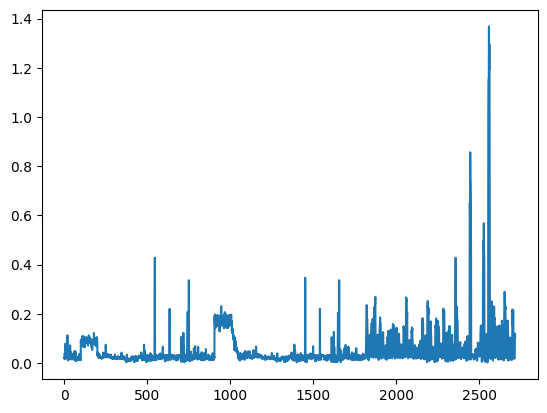

In [ ]:
df_drift_exposure["FDDS"].plot()

In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# Load MLS Drift Exposure Scores (if not already in memory)
# ============================================================
# df_drift_exposure = pd.read_csv("electricity_drift_exposure_scores.csv")

# ============================================================
# Configuration
# ============================================================
block_group_size = 5    # Number of blocks per group
threshold_scaled = 0.01  # Scaled drift threshold (0–1 range)

# ============================================================
# Step 1: Assign group IDs (every 5 blocks form a group)
# ============================================================
df_drift_exposure["block_group"] = (df_drift_exposure["block"] // block_group_size).astype(int)

# ============================================================
# Step 2: Aggregate by group — compute average DES per block group
# ============================================================
group_results = []
for group_id, subset in df_drift_exposure.groupby("block_group"):
    avg_des = subset["FDDS"].mean()
    group_results.append({
        "block_range": f"{subset['block'].min():.0f}-{subset['block'].max():.0f}",
        "total_blocks": len(subset),
        "avg_FDDS": avg_des
    })

df_summary = pd.DataFrame(group_results)

# ============================================================
# Step 3: Scale avg_DES into [0, 1] range for comparison
# ============================================================
min_val = df_summary["avg_FDDS"].min()
max_val = df_summary["avg_FDDS"].max()
df_summary["avg_FDDS_scaled"] = (df_summary["avg_FDDS"] - min_val) / (max_val - min_val)

# ============================================================
# Step 4: Determine drift type based on scaled DES threshold
# ============================================================
df_summary["final_drift"] = np.where(
    df_summary["avg_FDDS_scaled"] > threshold_scaled,
    "REAL_DRIFT",
    "PSEUDO_DRIFT"
)

# ============================================================
# Save and display
# ============================================================
df_summary.to_csv("electricity_drift_summary.csv", index=False)

print("✅ Drift summary saved to electricity_drift_summary.csv")
print(df_summary)


✅ Drift summary saved to electricity_drift_summary.csv
    block_range  total_blocks  avg_FDDS  avg_FDDS_scaled   final_drift
0           0-4             5  0.023688         0.010978    REAL_DRIFT
1           5-9             5  0.055318         0.038044    REAL_DRIFT
2         10-14             5  0.042802         0.027334    REAL_DRIFT
3         15-19             5  0.056798         0.039310    REAL_DRIFT
4         20-24             5  0.014178         0.002839  PSEUDO_DRIFT
..          ...           ...       ...              ...           ...
539   2695-2699             5  0.022333         0.009818  PSEUDO_DRIFT
540   2700-2704             5  0.161898         0.129248    REAL_DRIFT
541   2705-2709             5  0.133232         0.104717    REAL_DRIFT
542   2710-2714             5  0.019842         0.007686  PSEUDO_DRIFT
543   2715-2718             4  0.081590         0.060525    REAL_DRIFT

[544 rows x 5 columns]


In [ ]:
df_summary.to_csv("MDDP_5_Electricity.csv", index=False)

In [ ]:
df_summary['final_drift'].value_counts()

,count
final_drift,
REAL_DRIFT,405
PSEUDO_DRIFT,139


In [ ]:
df_summary

,block_range,total_blocks,avg_FDDS,avg_FDDS_scaled,final_drift
0,0-4,5,0.023688,0.010978,REAL_DRIFT
1,5-9,5,0.055318,0.038044,REAL_DRIFT
2,10-14,5,0.042802,0.027334,REAL_DRIFT
3,15-19,5,0.056798,0.039310,REAL_DRIFT
4,20-24,5,0.014178,0.002839,PSEUDO_DRIFT
...,...,...,...,...,...
539,2695-2699,5,0.022333,0.009818,PSEUDO_DRIFT
540,2700-2704,5,0.161898,0.129248,REAL_DRIFT
541,2705-2709,5,0.133232,0.104717,REAL_DRIFT
542,2710-2714,5,0.019842,0.007686,PSEUDO_DRIFT


In [ ]:
df_all.to_csv("Drifted_Elec_data.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ============================================================
# Configuration
# ============================================================
features = ["nswprice", "vicprice", "transfer", "vicdemand"]
target = "class"
block_window = 5  # evaluate every 5 consecutive blocks

# ============================================================
# Input DataFrame (combined drift dataset)
# ============================================================
df_tmp = df_all.copy()
df_tmp = df_tmp.sort_values(by="block").reset_index(drop=True)

# ============================================================
# Encode target labels
# ============================================================
le = LabelEncoder()
df_tmp[target] = le.fit_transform(df_tmp[target])  # UP/DOWN → 0/1

# ============================================================
# Evaluate model performance per 5-block chunk
# ============================================================
accuracies = []
block_ids = sorted(df_tmp["block"].unique())

for i in range(0, len(block_ids), block_window):
    block_chunk = block_ids[i:i + block_window]
    df_chunk = df_tmp[df_tmp["block"].isin(block_chunk)]
    if df_chunk.empty:
        continue

    # Prepare feature and label arrays
    X_chunk = df_chunk[features].values
    y_chunk = df_chunk[target].values

    # Scale using the same fitted scaler
    X_chunk_scaled = scaler.transform(pd.DataFrame(X_chunk, columns=features))

    # Evaluate accuracy for this chunk
    accuracy = model.score(X_chunk_scaled, y_chunk)

    accuracies.append({
        "block_range": f"{block_chunk[0]}-{block_chunk[-1]}",
        "total_blocks": len(block_chunk),
        "accuracy": accuracy
    })

# ============================================================
# Build summary DataFrame
# ============================================================
df_accuracies = pd.DataFrame(accuracies)

# Save for later drift comparison (ground truth)
df_accuracies.to_csv("electricity_blockwise_accuracies.csv", index=False)

print("✅ Block-wise accuracy ground truth saved to electricity_blockwise_accuracies.csv")
print(df_accuracies.head())


✅ Block-wise accuracy ground truth saved to electricity_blockwise_accuracies.csv
  block_range  total_blocks  accuracy
0         0-4             5     0.648
1         5-9             5     0.668
2       10-14             5     0.760
3       15-19             5     0.720
4       20-24             5     0.904


In [ ]:
df_accuracies.to_csv("Ground_5_Electricity.csv")

In [ ]:
import numpy as np
# Assume df is your dataframe with 'accuracy'
df_accuracies["Ground truth"] = np.where(df_accuracies["accuracy"] > 0.85, "PSEUDO_DRIFT", "REAL_DRIFT")
df_accuracies

,block_range,total_blocks,accuracy,Ground truth
0,0-4,5,0.648000,REAL_DRIFT
1,5-9,5,0.668000,REAL_DRIFT
2,10-14,5,0.760000,REAL_DRIFT
3,15-19,5,0.720000,REAL_DRIFT
4,20-24,5,0.904000,PSEUDO_DRIFT
...,...,...,...,...
539,2695-2699,5,0.740000,REAL_DRIFT
540,2700-2704,5,0.536000,REAL_DRIFT
541,2705-2709,5,0.584000,REAL_DRIFT
542,2710-2714,5,0.768000,REAL_DRIFT


<Axes: >

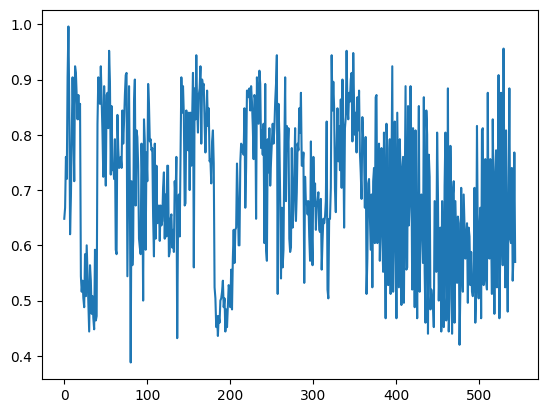

In [ ]:
df_accuracies["accuracy"].plot()

In [ ]:
df_accuracies['Ground truth'].value_counts()

,count
Ground truth,
REAL_DRIFT,458
PSEUDO_DRIFT,86


In [ ]:
df_accuracies.to_csv("Ground_Electricity.csv", index=False)

In [ ]:
df_accuracies['Fixed Threshold'] = df_summary['final_drift']
df_accuracies['avg_DES_scaled'] = df_summary['avg_DES_scaled']

In [ ]:
df_accuracies.rename(columns={"total_blocks": "window_size"}, inplace=True)

In [ ]:
df_accuracies.to_csv("adaptive_drift_results_ele.csv", index=False)

In [ ]:
df_summary

,block_range,total_blocks,avg_DES,avg_DES_scaled,final_drift
0,0-4,5,0.023688,0.010978,REAL_DRIFT
1,5-9,5,0.055318,0.038044,REAL_DRIFT
2,10-14,5,0.042802,0.027334,REAL_DRIFT
3,15-19,5,0.056798,0.039310,REAL_DRIFT
4,20-24,5,0.014178,0.002839,PSEUDO_DRIFT
...,...,...,...,...,...
539,2695-2699,5,0.022333,0.009818,PSEUDO_DRIFT
540,2700-2704,5,0.161898,0.129248,REAL_DRIFT
541,2705-2709,5,0.133232,0.104717,REAL_DRIFT
542,2710-2714,5,0.019842,0.007686,PSEUDO_DRIFT


In [ ]:
df_summary["final_drift"].value_counts()

,count
final_drift,
REAL_DRIFT,405
PSEUDO_DRIFT,139


In [ ]:
df_summary

,block_range,total_blocks,avg_DES,avg_DES_scaled,final_drift
0,0-4,5,0.023688,0.010978,REAL_DRIFT
1,5-9,5,0.055318,0.038044,REAL_DRIFT
2,10-14,5,0.042802,0.027334,REAL_DRIFT
3,15-19,5,0.056798,0.039310,REAL_DRIFT
4,20-24,5,0.014178,0.002839,PSEUDO_DRIFT
...,...,...,...,...,...
539,2695-2699,5,0.022333,0.009818,PSEUDO_DRIFT
540,2700-2704,5,0.161898,0.129248,REAL_DRIFT
541,2705-2709,5,0.133232,0.104717,REAL_DRIFT
542,2710-2714,5,0.019842,0.007686,PSEUDO_DRIFT


In [ ]:
df_summary.to_csv("df_des_gradual_electricity.csv")

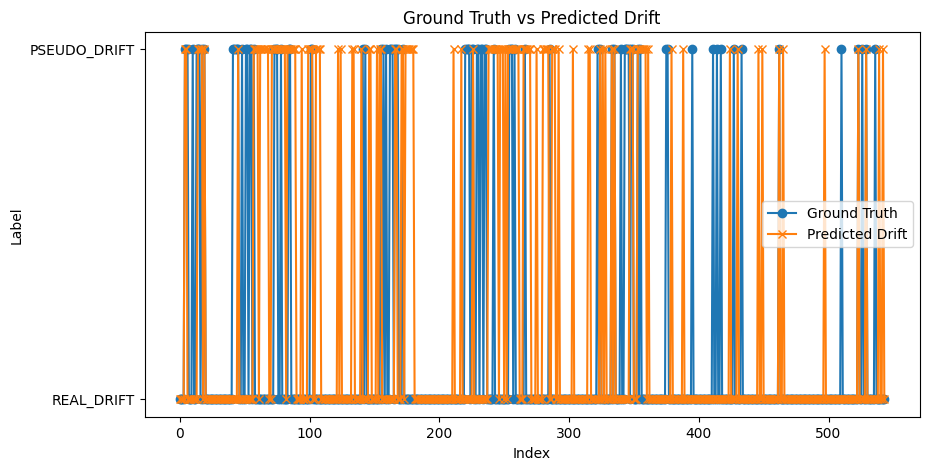

In [ ]:
import matplotlib.pyplot as plt
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
plt.figure(figsize=(10,5))
plt.plot(y_true.values, label="Ground Truth", marker='o')
plt.plot(y_pred.values, label="Predicted Drift", marker='x')
plt.xlabel("Index")
plt.ylabel("Label")
plt.title("Ground Truth vs Predicted Drift")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7224264705882353
F1 Score: 0.7465950590355879
Precision: 0.7821318761983876
Recall: 0.7224264705882353
Confusion Matrix:
 [[ 37  49]
 [102 356]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.27      0.43      0.33        86
  REAL_DRIFT       0.88      0.78      0.83       458

    accuracy                           0.72       544
   macro avg       0.57      0.60      0.58       544
weighted avg       0.78      0.72      0.75       544



In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_all.to_csv("/content/drive/My Drive/Early Drift Detection/Drifted_Elec_data.csv", index=False)

**ADWIN Electricity**
---

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Define the paths to your datasets in Google Drive
import numpy as np
df_all=pd.read_csv("/content/drive/My Drive/Early Drift Detection/Drifted_Elec_data.csv")
df_all

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type,block
0,0.000000,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1,0
1,1.000000,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1,0
2,2.000000,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1,0
3,3.000000,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1,0
4,4.000000,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1,0
...,...,...,...,...,...,...,...,...
135931,45269.030681,0.018423,-0.000521,0.427484,1.061036,UP,recurrent,2718
135932,45081.173802,-0.084473,0.019881,0.370847,0.856688,UP,recurrent,2718
135933,45209.121544,0.007201,0.005652,1.938911,-0.644469,UP,recurrent,2718
135934,45360.881253,0.120024,0.003904,0.097692,-0.934170,DOWN,recurrent,2718


In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
# ==========================================================
# VARIANCE-AWARE ADWIN DRIFT DETECTOR
# ==========================================================
def adwin_detector_single_feature(data_stream, delta=0.002, min_window=10):
    """
    ADWIN for single feature — now variance-aware.
    Returns drift scores (0–1) combining mean + variance shift effects.
    """
    window = []
    drift_scores = np.zeros(len(data_stream))

    for i, value in enumerate(data_stream):
        window.append(value)

        if len(window) < min_window:
            continue

        n = len(window)
        split_points = [int(0.3 * n), int(0.5 * n), int(0.7 * n)]
        max_drift_score = 0

        for split_point in split_points:
            if split_point < 5 or (n - split_point) < 5:
                continue

            w0 = np.array(window[:split_point])
            w1 = np.array(window[split_point:])

            n0, n1 = len(w0), len(w1)
            m = 1 / (1 / n0 + 1 / n1)

            mean0, mean1 = np.mean(w0), np.mean(w1)
            var0, var1 = np.var(w0), np.var(w1)

            pooled_var = ((n0 - 1) * var0 + (n1 - 1) * var1) / (n0 + n1 - 2)
            δ_prime = delta / n
            ε_cut = np.sqrt((2 / m) * pooled_var * np.log(2 / δ_prime)) + (2 / (3 * m)) * np.log(2 / δ_prime)

            # --- Mean difference component ---
            mean_diff = abs(mean0 - mean1)

            # --- Variance difference component (normalized) ---
            var_diff = abs(np.sqrt(var0) - np.sqrt(var1))

            # --- Combined drift magnitude (normalized) ---
            drift_mag = np.sqrt(mean_diff**2 + var_diff**2)

            # --- Relative drift score vs. threshold ---
            drift_score = min(1.0, drift_mag / (ε_cut + 1e-8))
            max_drift_score = max(max_drift_score, drift_score)

            # Adaptive window shrink if strong drift detected
            if drift_score > 0.7:
                window = w1.tolist()
                break

        drift_scores[i] = max_drift_score

        # Rolling window control
        if len(window) > 50:
            window = window[-25:]

    return drift_scores
# ==================== BLOCKWISE COMBINATION (ADWIN ONLY) ====================
def combine_adwin_drift_scores_blockwise(df, adwin_scores_dict, adwin_threshold=0.6, block_size=5):
    """
    Combine ADWIN drift scores from all features using block averages.
    Classifies each block as REAL_DRIFT or PSEUDO_DRIFT.
    Also prints and stores ADWIN block means for tuning.
    """
    df["block_group"] = (df["block"] // block_size).astype(int)
    adwin_block_labels = {}
    adwin_block_means = {}

    print("\n=== BLOCK-WISE ADWIN MEAN SCORES ===")
    for group_id, group_df in df.groupby("block_group"):
        idx = group_df.index
        adwin_block_mean = np.mean([np.mean(adwin_scores_dict[col][idx]) for col in adwin_scores_dict])

        adwin_block_means[group_id] = adwin_block_mean  # store numeric value
        if adwin_block_mean > adwin_threshold:
            adwin_block_labels[group_id] = "REAL_DRIFT"
        else:
            adwin_block_labels[group_id] = "PSEUDO_DRIFT"

        # Print block statistics for inspection
        print(f"Block {group_id:3d}: Mean Score = {adwin_block_mean:.4f} → {adwin_block_labels[group_id]}")

    # Map results to dataframe
    df["ADWIN_drift"] = df["block_group"].map(adwin_block_labels)
    df["ADWIN_score_mean"] = df["block_group"].map(adwin_block_means)

    return df
# ==================== MAIN FUNCTION ====================
def detect_adwin_drift_all_columns(df, feature_columns=None, adwin_threshold=0.6, block_size=5):
    """
    Main function: Detect ADWIN drift on all specified columns with block averaging
    """
    if feature_columns is None:
        exclude_cols = ['activity', 'drift_type', 'block']
        feature_columns = [col for col in df.columns if col not in exclude_cols and
                           pd.api.types.is_numeric_dtype(df[col])]

    print(f"Processing {len(feature_columns)} features: {feature_columns}")

    adwin_scores_dict = {}

    for col in feature_columns:
        print(f"Calculating ADWIN drift scores for {col}...")
        data = df[col].values
        adwin_scores_dict[col] = adwin_detector_single_feature(data)

    print("\nCombining ADWIN drift scores block-wise...")
    result_df = combine_adwin_drift_scores_blockwise(df.copy(), adwin_scores_dict,
                                                     adwin_threshold, block_size)

    adwin_real = (result_df['ADWIN_drift'] == 'REAL_DRIFT').sum()
    adwin_pseudo = (result_df['ADWIN_drift'] == 'PSEUDO_DRIFT').sum()

    print(f"\n=== ADWIN DRIFT DETECTION SUMMARY ===")
    print(f"REAL_DRIFT blocks: {adwin_real}")
    print(f"PSEUDO_DRIFT blocks: {adwin_pseudo}")
    print(f"Total blocks: {result_df['block_group'].nunique()}")

    return result_df
# ==================== SIMPLE USAGE ====================
def run_adwin_drift_detection(df_all, adwin_threshold=0.001, block_size=5):
    return detect_adwin_drift_all_columns(df_all, adwin_threshold=adwin_threshold, block_size=block_size)

In [ ]:
df_all

,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type,block
0,0.000000,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1,0
1,1.000000,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1,0
2,2.000000,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1,0
3,3.000000,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1,0
4,4.000000,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1,0
...,...,...,...,...,...,...,...,...
135931,45269.030681,0.018423,-0.000521,0.427484,1.061036,UP,recurrent,2718
135932,45081.173802,-0.084473,0.019881,0.370847,0.856688,UP,recurrent,2718
135933,45209.121544,0.007201,0.005652,1.938911,-0.644469,UP,recurrent,2718
135934,45360.881253,0.120024,0.003904,0.097692,-0.934170,DOWN,recurrent,2718


In [ ]:
result = detect_adwin_drift_all_columns(
    df_all,
    feature_columns=[
        'nswprice',	'vicprice',	'transfer','vicdemand'
    ],
    adwin_threshold=0.10,  # start with small threshold since data now normalized
    block_size=5
)
# Check block-level drift means
print("\n--- Drift Counts ---")
print(result['ADWIN_drift'].value_counts())
# Inspect block mean scores
print(result[['block_group', 'ADWIN_score_mean', 'ADWIN_drift']].drop_duplicates().head(20))
# Save results
result.to_csv('adwin_drift_detection_results.csv', index=False)

Processing 4 features: ['nswprice', 'vicprice', 'transfer', 'vicdemand']
Calculating ADWIN drift scores for nswprice...
Calculating ADWIN drift scores for vicprice...
Calculating ADWIN drift scores for transfer...
Calculating ADWIN drift scores for vicdemand...

Combining ADWIN drift scores block-wise...

=== BLOCK-WISE ADWIN MEAN SCORES ===
Block   0: Mean Score = 0.0051 → PSEUDO_DRIFT
Block   1: Mean Score = 0.0124 → PSEUDO_DRIFT
Block   2: Mean Score = 0.0102 → PSEUDO_DRIFT
Block   3: Mean Score = 0.0118 → PSEUDO_DRIFT
Block   4: Mean Score = 0.0113 → PSEUDO_DRIFT
Block   5: Mean Score = 0.0057 → PSEUDO_DRIFT
Block   6: Mean Score = 0.0078 → PSEUDO_DRIFT
Block   7: Mean Score = 0.0117 → PSEUDO_DRIFT
Block   8: Mean Score = 0.0063 → PSEUDO_DRIFT
Block   9: Mean Score = 0.0056 → PSEUDO_DRIFT
Block  10: Mean Score = 0.0052 → PSEUDO_DRIFT
Block  11: Mean Score = 0.0060 → PSEUDO_DRIFT
Block  12: Mean Score = 0.0081 → PSEUDO_DRIFT
Block  13: Mean Score = 0.0116 → PSEUDO_DRIFT
Block  14: M

<Axes: >

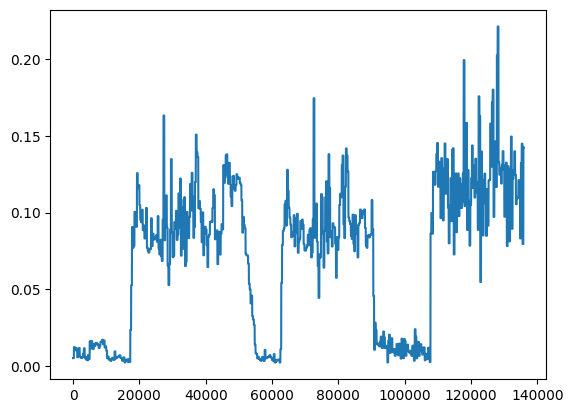

In [ ]:
result['ADWIN_score_mean'].plot()

In [ ]:
result['ADWIN_drift'].value_counts()

,count
ADWIN_drift,
PSEUDO_DRIFT,93500
REAL_DRIFT,42436


In [ ]:
def majority_drift(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else "NO_DATA"

# Step 3: Aggregate per block_group
agg_results = result.groupby("block_group").agg({
    "ADWIN_drift": majority_drift
}).reset_index()

# Step 4: Add block range string
agg_results["block_range"] = agg_results["block_group"].apply(lambda g: f"{g*5}-{g*5+4}")
agg_results

,block_group,ADWIN_drift,block_range
0,0,PSEUDO_DRIFT,0-4
1,1,PSEUDO_DRIFT,5-9
2,2,PSEUDO_DRIFT,10-14
3,3,PSEUDO_DRIFT,15-19
4,4,PSEUDO_DRIFT,20-24
...,...,...,...
539,539,PSEUDO_DRIFT,2695-2699
540,540,REAL_DRIFT,2700-2704
541,541,REAL_DRIFT,2705-2709
542,542,PSEUDO_DRIFT,2710-2714


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:544]
y_pred = agg_results["ADWIN_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.6378676470588235
F1 Score: 0.67127295942943
Precision: 0.7221856322743001
Recall: 0.6378676470588235
Confusion Matrix:
 [[312 135]
 [ 62  35]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.83      0.70      0.76       447
  REAL_DRIFT       0.21      0.36      0.26        97

    accuracy                           0.64       544
   macro avg       0.52      0.53      0.51       544
weighted avg       0.72      0.64      0.67       544



***MMD DETECTOR Electricity***
---

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ============================================================
# MMD DETECTOR (SINGLE FEATURE)
# ============================================================
def mmd_detector_single_feature(data_stream, window_size=20):
    """
    Mean Maximum Discrepancy (MMD) for single feature - returns drift scores (0–1).
    """
    def rbf_kernel(x, y, sigma=1.0):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)
        dist_sq = np.sum(x**2, axis=1, keepdims=True) + np.sum(y**2, axis=1) - 2 * (x @ y.T)
        return np.exp(-dist_sq / (2 * sigma**2))

    reference = []
    current = []
    drift_scores = np.zeros(len(data_stream))

    for i, value in enumerate(data_stream):
        current.append(value)

        if len(current) > window_size:
            current = current[-window_size:]

        if len(reference) < window_size:
            reference.append(value)
            continue

        # Compute kernel matrices
        K_ref = rbf_kernel(reference, reference)
        K_curr = rbf_kernel(current, current)
        K_cross = rbf_kernel(reference, current)

        m, n = len(reference), len(current)
        mmd_sq = (np.sum(K_ref) - np.trace(K_ref)) / (m*(m-1)) \
                 + (np.sum(K_curr) - np.trace(K_curr)) / (n*(n-1)) \
                 - 2 * np.mean(K_cross)

        mmd_sq = max(0, mmd_sq)
        drift_score = min(1.0, mmd_sq * 10)  # scale factor for normalization
        drift_scores[i] = drift_score

        # Update reference window when strong drift detected
        if drift_score > 0.8:
            reference = current.copy()

    return drift_scores


# ============================================================
# COMBINE MMD DRIFT SCORES BLOCKWISE
# ============================================================
def combine_mmd_drift_scores_blockwise(df, mmd_scores_dict, mmd_threshold=0.7, block_size=5):
    """
    Combine MMD drift scores from all features using block averages (scaled 0–1).
    """
    df["block_group"] = (df["block"] // block_size).astype(int)
    mmd_block_means = []

    # Compute average drift score per block across all features
    for group_id, group_df in df.groupby("block_group"):
        idx = group_df.index
        mean_score = np.mean([
            np.mean(mmd_scores_dict[col][idx]) for col in mmd_scores_dict
        ])
        mmd_block_means.append((group_id, mean_score))

    # Convert to DataFrame for scaling
    mmd_block_df = pd.DataFrame(mmd_block_means, columns=["block_group", "MMD_score_mean"])

    # --- Scale block means between 0 and 1 ---
    scaler = MinMaxScaler()
    mmd_block_df["MMD_score_mean_scaled"] = scaler.fit_transform(
        mmd_block_df[["MMD_score_mean"]]
    )

    # --- Classify scaled means ---
    mmd_block_df["MMD_drift"] = np.where(
        mmd_block_df["MMD_score_mean_scaled"] > mmd_threshold,
        "real_drift",
        "pseudo_drift"
    )

    # Merge results back into original DataFrame
    df = df.merge(mmd_block_df, on="block_group", how="left")

    return df


# ============================================================
# MAIN FUNCTION (ELECTRICITY DATASET ADAPTATION)
# ============================================================
def detect_mmd_drift_all_columns(df, feature_columns=None, mmd_threshold=0.7, block_size=5):
    """
    Detect drift on all numeric columns using MMD-based scoring.
    Adapted for electricity dataset (nswprice, vicprice, transfer, vicdemand).
    """
    # --- Convert safely to numeric where possible ---
    df = df.apply(pd.to_numeric, errors='ignore')

    # --- Define features ---
    if feature_columns is None:
        exclude_cols = ['class', 'drift_type', 'block']
        feature_columns = [
            col for col in df.columns
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])
        ]

    print(f"Processing {len(feature_columns)} features: {feature_columns}")

    # --- Compute drift scores per feature ---
    mmd_scores_dict = {}
    for col in feature_columns:
        print(f"Calculating MMD drift scores for {col}...")
        data = df[col].values
        mmd_scores_dict[col] = mmd_detector_single_feature(data)

    print("\nCombining MMD drift scores block-wise...")
    result_df = combine_mmd_drift_scores_blockwise(
        df.copy(), mmd_scores_dict, mmd_threshold, block_size
    )

    # --- Summary ---
    mmd_real = (result_df['MMD_drift'] == 'real_drift').sum()
    mmd_pseudo = (result_df['MMD_drift'] == 'pseudo_drift').sum()

    print("\n=== MMD DRIFT DETECTION SUMMARY ===")
    print(f"Real drifts: {mmd_real}")
    print(f"Pseudo drifts: {mmd_pseudo}")
    print(f"Total block groups: {result_df['block_group'].nunique()}")

    return result_df


# ============================================================
# SIMPLE USAGE WRAPPER
# ============================================================
def run_mmd_drift_detection(df, mmd_threshold=0.7, block_size=5):
    """
    Simplified interface for running MMD drift detection end-to-end.
    """
    return detect_mmd_drift_all_columns(df, mmd_threshold=mmd_threshold, block_size=block_size)


In [ ]:
# ==================== RUN MMD DRIFT DETECTION ====================
result = detect_mmd_drift_all_columns(
    df_all,
    feature_columns=['nswprice', 'vicprice', 'transfer', 'vicdemand'],
    mmd_threshold=0.4,  # adjust based on sensitivity
    block_size=5
)

# --- Drift counts summary ---
print("\n--- Drift Counts ---")
print(result['MMD_drift'].value_counts())

# --- Compute block-level mean of numeric features (for inspection) ---
numeric_cols = [
    col for col in result.columns
    if col not in ['class', 'drift_type', 'block', 'block_group', 'MMD_drift']
    and pd.api.types.is_numeric_dtype(result[col])
]

block_means = (
    result.groupby('block_group')[numeric_cols]
    .mean()
    .mean(axis=1)
)

# Map these mean scores back to the main DataFrame
result['MMD_score_mean_computed'] = result['block_group'].map(block_means)

# --- Display sample results ---
print("\n--- Block Mean Scores ---")
print(
    result[['block_group', 'MMD_score_mean_computed', 'MMD_drift']]
    .drop_duplicates()
    .head(20)
)

# --- Save results ---
result.to_csv('mmd_drift_detection_results.csv', index=False)
print("\n✅ Results saved to 'mmd_drift_detection_results.csv'")

/tmp/ipython-input-3559855736.py:102: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


Processing 4 features: ['nswprice', 'vicprice', 'transfer', 'vicdemand']
Calculating MMD drift scores for nswprice...
Calculating MMD drift scores for vicprice...
Calculating MMD drift scores for transfer...
Calculating MMD drift scores for vicdemand...

Combining MMD drift scores block-wise...

=== MMD DRIFT DETECTION SUMMARY ===
Real drifts: 45936
Pseudo drifts: 90000
Total block groups: 544

--- Drift Counts ---
MMD_drift
pseudo_drift    90000
real_drift      45936
Name: count, dtype: int64

--- Block Mean Scores ---
      block_group  MMD_score_mean_computed     MMD_drift
0               0                17.915366  pseudo_drift
250             1                53.645413  pseudo_drift
500             2                89.354764  pseudo_drift
750             3               125.076033  pseudo_drift
1000            4               160.774952  pseudo_drift
1250            5               196.485094  pseudo_drift
1500            6               232.204242  pseudo_drift
1750            7 

In [ ]:
result['MMD_drift'].value_counts()

,count
MMD_drift,
pseudo_drift,90000
real_drift,45936


In [ ]:
result

,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type,block,block_group,MMD_score_mean,MMD_score_mean_scaled,MMD_drift,MMD_score_mean_computed
0,0.000000,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1,0,0,0.001361,0.006939,pseudo_drift,17.915366
1,1.000000,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1,0,0,0.001361,0.006939,pseudo_drift,17.915366
2,2.000000,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1,0,0,0.001361,0.006939,pseudo_drift,17.915366
3,3.000000,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1,0,0,0.001361,0.006939,pseudo_drift,17.915366
4,4.000000,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1,0,0,0.001361,0.006939,pseudo_drift,17.915366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135931,45269.030681,0.018423,-0.000521,0.427484,1.061036,UP,recurrent,2718,543,0.105034,0.575956,real_drift,6445.992627
135932,45081.173802,-0.084473,0.019881,0.370847,0.856688,UP,recurrent,2718,543,0.105034,0.575956,real_drift,6445.992627
135933,45209.121544,0.007201,0.005652,1.938911,-0.644469,UP,recurrent,2718,543,0.105034,0.575956,real_drift,6445.992627
135934,45360.881253,0.120024,0.003904,0.097692,-0.934170,DOWN,recurrent,2718,543,0.105034,0.575956,real_drift,6445.992627


In [ ]:
def majority_drift(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else "NO_DATA"
# Step 3: Aggregate per block_group
agg_results = result.groupby("block_group").agg({
    "MMD_drift": majority_drift
}).reset_index()
agg_results["block_range"] = agg_results["block_group"].apply(lambda g: f"{g*5}-{g*5+4}")
agg_results

,block_group,MMD_drift,block_range
0,0,pseudo_drift,0-4
1,1,pseudo_drift,5-9
2,2,pseudo_drift,10-14
3,3,pseudo_drift,15-19
4,4,pseudo_drift,20-24
...,...,...,...
539,539,real_drift,2695-2699
540,540,pseudo_drift,2700-2704
541,541,real_drift,2705-2709
542,542,real_drift,2710-2714


In [ ]:
agg_results["MMD_drift"] = agg_results["MMD_drift"].replace("pseudo_drift", "PSEUDO_DRIFT")
agg_results["MMD_drift"] = agg_results["MMD_drift"].replace("real_drift", "REAL_DRIFT")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:544]
y_pred = agg_results["MMD_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.6268382352941176
F1 Score: 0.664490602429703
Precision: 0.7271013160699062
Recall: 0.6268382352941176
Confusion Matrix:
 [[302 145]
 [ 58  39]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.84      0.68      0.75       447
  REAL_DRIFT       0.21      0.40      0.28        97

    accuracy                           0.63       544
   macro avg       0.53      0.54      0.51       544
weighted avg       0.73      0.63      0.66       544



**D3**
---

In [ ]:
df_all

,Unnamed: 0,nswprice,vicprice,transfer,vicdemand,class,drift_type,block
0,0.000000,0.056443,0.003467,0.414912,0.422915,UP,sudden_type1,0
1,1.000000,0.051699,0.003467,0.414912,0.422915,UP,sudden_type1,0
2,2.000000,0.051489,0.003467,0.414912,0.422915,UP,sudden_type1,0
3,3.000000,0.045485,0.003467,0.414912,0.422915,UP,sudden_type1,0
4,4.000000,0.042482,0.003467,0.414912,0.422915,DOWN,sudden_type1,0
...,...,...,...,...,...,...,...,...
135931,45269.030681,0.018423,-0.000521,0.427484,1.061036,UP,recurrent,2718
135932,45081.173802,-0.084473,0.019881,0.370847,0.856688,UP,recurrent,2718
135933,45209.121544,0.007201,0.005652,1.938911,-0.644469,UP,recurrent,2718
135934,45360.881253,0.120024,0.003904,0.097692,-0.934170,DOWN,recurrent,2718


In [ ]:
import numpy as np
import pandas as pd

def make_blockgroup_features(df, feature_columns, block_size=5):
    df = df.copy()
    df["block_group"] = (df["block"] // block_size).astype(int)

    # One vector per block_group (mean per sensor axis)
    X_bg = (
        df.groupby("block_group")[feature_columns]
          .mean()
          .reset_index()
          .sort_values("block_group")
          .reset_index(drop=True)
    )
    return X_bg  # columns: block_group + 6 sensor means


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def d3_detector_multifeature(X_stream, w=20, rho=0.2, tau=0.7):
    """
    X_stream: numpy array shape (T, d)
    returns:
      drift_flags: array length T (True/False)
      auc_scores:  array length T (float)
    """
    T = X_stream.shape[0]
    new_size = max(2, int(w * rho))     # must be >=2 for stable AUC
    old_size = w

    drift_flags = np.zeros(T, dtype=bool)
    auc_scores  = np.zeros(T, dtype=float)

    # rolling reference index update (matches D3 idea: when drift -> advance faster)
    start = 0
    while True:
        end = start + old_size + new_size
        if end > T:
            break

        old = X_stream[start : start + old_size]
        new = X_stream[start + old_size : end]

        X = np.vstack([old, new])
        s = np.hstack([np.zeros(old.shape[0]), np.ones(new.shape[0])])

        # scale inside the window (important for HAR axes)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        clf = LogisticRegression(max_iter=200, solver="lbfgs")
        clf.fit(Xs, s)

        # AUC on the same window (baseline style; you can add CV later if you want)
        probs = clf.predict_proba(Xs)[:, 1]
        auc = roc_auc_score(s, probs)

        # write score at the last index of the new window (decision time)
        decision_t = end - 1
        auc_scores[decision_t] = auc
        drift_flags[decision_t] = (auc >= tau)

        # D3-style window shift: if drift, drop w; else drop w*rho
        if drift_flags[decision_t]:
            start = start + old_size
        else:
            start = start + new_size

    return drift_flags, auc_scores


In [ ]:
def run_d3_baseline(df_all, feature_columns, block_size=5, w=20, rho=0.2, tau=0.7):
    # Step A: build block_group feature stream
    X_bg = make_blockgroup_features(df_all, feature_columns, block_size=block_size)
    X_stream = X_bg[feature_columns].values
    drift_flags, auc_scores = d3_detector_multifeature(X_stream, w=w, rho=rho, tau=tau)
    # Step B: convert to your labels at block_group level
    pred = np.where(drift_flags, "REAL_DRIFT", "PSEUDO_DRIFT")
    agg_results = pd.DataFrame({
        "block_group": X_bg["block_group"].values,
        "D3_AUC": auc_scores,
        "D3_drift": pred
    })
    # Optional: create block_range like you did
    agg_results["block_range"] = agg_results["block_group"].apply(
        lambda g: f"{g*block_size}-{g*block_size+(block_size-1)}"
    )
    return agg_results

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

df_accuracies = pd.read_csv("/content/Ground.csv")

y_true = df_accuracies["Ground truth"][:544]

agg_results_d3 = run_d3_baseline(
    df_all,
    feature_columns=['nswprice', 'vicprice', 'transfer', 'vicdemand'],
    block_size=5,
    w=20, rho=0.2, tau=0.3
)

y_pred = agg_results_d3["D3_drift"].values

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.7904411764705882
F1 Score: 0.7388999720487847
Precision: 0.708491622524789
Recall: 0.7904411764705882
Confusion Matrix:
 [[425  22]
 [ 92   5]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.82      0.95      0.88       447
  REAL_DRIFT       0.19      0.05      0.08        97

    accuracy                           0.79       544
   macro avg       0.50      0.50      0.48       544
weighted avg       0.71      0.79      0.74       544



**STUDD**
---

**Teacher Student Model**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# -----------------------------
# 1) Prepare df_all (Electricity)
# -----------------------------
df = df_all.copy().reset_index(drop=True)

# Ensure streaming order is preserved (ONLY if you have a time column)
# df = df.sort_values("date").reset_index(drop=True)

# Ensure block exists (your later code depends on df["block"])
if "block" not in df.columns:
    df["block"] = np.arange(len(df))

# Features + target (as per your electricity example)
features = ["nswprice", "vicprice", "transfer", "vicdemand"]
target = "class"

X = df[features].values
y = df[target].values

# Encode labels -> 0/1
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split (teacher training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# -----------------------------
# 2) Teacher model (MLP)
# -----------------------------
teacher = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)

teacher.fit(X_train_sc, y_train)

# Teacher predictions
y_pred_teacher = teacher.predict(X_test_sc)

print("Teacher Accuracy:", accuracy_score(y_test, y_pred_teacher))
print("Teacher Confusion Matrix:\n", confusion_matrix(y_test, y_pred_teacher))


Teacher Accuracy: 0.7050342071062504
Teacher Confusion Matrix:
 [[16589  5629]
 [ 6400 12163]]


In [ ]:
from scipy.special import rel_entr

# -----------------------------------
# 3) Distillation targets (teacher probs)
# -----------------------------------
X_all = df[features].values
X_all_sc = scaler.transform(X_all)  # use SAME scaler from teacher training

teacher_probs = teacher.predict_proba(X_all_sc)   # soft labels (N x C)

# -----------------------------------
# 4) Student model (compact MLP)
# -----------------------------------
student = MLPClassifier(
    hidden_layer_sizes=(8,),   # smaller student
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)

# Student train-test split (imitating teacher)
Xs_train, Xs_test, ps_train, ps_test = train_test_split(
    X_all_sc, teacher_probs, test_size=0.3, random_state=42
)

# MLPClassifier cannot directly train on probability vectors as y.
# So we convert soft labels -> hard labels for training,
# BUT we still measure distillation disagreement using KL divergence later.
ps_train_hard = np.argmax(ps_train, axis=1)
ps_test_hard  = np.argmax(ps_test, axis=1)

student.fit(Xs_train, ps_train_hard)

print("Student trained to imitate teacher (hard from teacher_probs).")


Student trained to imitate teacher (hard from teacher_probs).


In [ ]:
def per_sample_kl(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(rel_entr(p, q), axis=1)  # KL(p||q) per row

# Teacher & student probs on full stream (same order)
T_probs = teacher.predict_proba(X_all_sc)
S_probs = student.predict_proba(X_all_sc)

# (A) Hard disagreement stream (0/1)
T_hat = np.argmax(T_probs, axis=1)
S_hat = np.argmax(S_probs, axis=1)
loss_stream_error = (T_hat != S_hat).astype(float)

# (B) Soft disagreement stream (KL)
loss_stream_kl = per_sample_kl(T_probs, S_probs)

print("Example error-loss values:", loss_stream_error[:10])
print("Example KL-loss values:", loss_stream_kl[:10])


Example error-loss values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example KL-loss values: [0.22688189 0.21801403 0.21778866 0.1713599  0.1515116  0.17382798
 0.17382798 0.17382798 0.17382798 0.17382798]


In [ ]:
def blockwise_loss_labels(df_all, loss_stream, block_size=5, threshold=0.3):
    df_tmp = df_all.copy().reset_index(drop=True)
    df_tmp["loss_raw"] = loss_stream  # original

    # Min-Max scale to [0,1]
    loss_min = df_tmp["loss_raw"].min()
    loss_max = df_tmp["loss_raw"].max()
    if loss_max > loss_min:
        df_tmp["loss"] = (df_tmp["loss_raw"] - loss_min) / (loss_max - loss_min)
    else:
        df_tmp["loss"] = 0.0

    # Ensure block exists
    if "block" not in df_tmp.columns:
        df_tmp["block"] = np.arange(len(df_tmp))

    # block group
    df_tmp["block_group"] = (df_tmp["block"] // block_size).astype(int)

    # aggregate
    bg = (
        df_tmp.groupby("block_group")["loss"]
        .mean()
        .reset_index()
        .sort_values("block_group")
    )

    # label
    bg["STUDD_drift"] = np.where(bg["loss"] > threshold, "REAL_DRIFT", "PSEUDO_DRIFT")
    bg["block_range"] = bg["block_group"].apply(
        lambda g: f"{g*block_size}-{g*block_size+(block_size-1)}"
    )

    return bg

agg_student_teacher = blockwise_loss_labels(
    df_all=df,
    loss_stream=loss_stream_kl,  # or loss_stream_error
    block_size=5,
    threshold=0.02
)

print(agg_student_teacher.head(20))
print(agg_student_teacher["STUDD_drift"].value_counts())


    block_group      loss   STUDD_drift block_range
0             0  0.014750  PSEUDO_DRIFT         0-4
1             1  0.029479    REAL_DRIFT         5-9
2             2  0.023397    REAL_DRIFT       10-14
3             3  0.027056    REAL_DRIFT       15-19
4             4  0.013380  PSEUDO_DRIFT       20-24
5             5  0.012882  PSEUDO_DRIFT       25-29
6             6  0.016915  PSEUDO_DRIFT       30-34
7             7  0.024673    REAL_DRIFT       35-39
8             8  0.015233  PSEUDO_DRIFT       40-44
9             9  0.017512  PSEUDO_DRIFT       45-49
10           10  0.016916  PSEUDO_DRIFT       50-54
11           11  0.015612  PSEUDO_DRIFT       55-59
12           12  0.018456  PSEUDO_DRIFT       60-64
13           13  0.018667  PSEUDO_DRIFT       65-69
14           14  0.010679  PSEUDO_DRIFT       70-74
15           15  0.012917  PSEUDO_DRIFT       75-79
16           16  0.012590  PSEUDO_DRIFT       80-84
17           17  0.013355  PSEUDO_DRIFT       85-89
18          

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

df_accuracies = pd.read_csv("/content/Ground.csv")

y_true = df_accuracies["Ground truth"][:544]
y_pred = agg_student_teacher["STUDD_drift"].values



print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.5533088235294118
F1 Score: 0.6018994157680861
Precision: 0.8001053720668595
Recall: 0.5533088235294118
Confusion Matrix:
 [[224 223]
 [ 20  77]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.92      0.50      0.65       447
  REAL_DRIFT       0.26      0.79      0.39        97

    accuracy                           0.55       544
   macro avg       0.59      0.65      0.52       544
weighted avg       0.80      0.55      0.60       544



**SCSD**
---

In [ ]:
# ============================================================
# JANG22 SEQUENTIAL CALIBRATED C2ST (COVARIATE SHIFT DETECTOR)
# ELECTRICITY VERSION: df_all (stream) + df_accuracies (ground truth)
# ============================================================

import numpy as np
import pandas as pd
from collections import deque
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# ============================================================
# 1) CLOPPER–PEARSON CONFIDENCE INTERVAL
# ============================================================
def clopper_pearson_interval(successes, n, alpha=0.05):
    s = int(successes)

    if s == 0:
        lo = 0.0
    else:
        lo = beta.ppf(alpha / 2, s, n - s + 1)

    if s == n:
        hi = 1.0
    else:
        hi = beta.ppf(1 - alpha / 2, s + 1, n - s)

    return lo, hi


# ============================================================
# 2) SEQUENTIAL C2ST WITH CP CALIBRATION (FAST + FIXED)
# ============================================================
def sequential_c2st_cp(
    df_all,
    feature_columns,
    source_df=None,
    source_size=500,
    w=50,
    alpha=0.05,
    random_state=42,
    check_every=1,
    return_debug=True,
    verbose_every=50000
):
    rng = np.random.default_rng(random_state)

    df_stream = df_all.reset_index(drop=True).copy()

    # (Optional) Keep streaming order if you have a time column
    # df_stream = df_stream.sort_values("date").reset_index(drop=True)

    if source_df is None:
        if source_size >= len(df_stream):
            raise ValueError("source_size must be smaller than len(df_all).")
        source_df = df_stream.iloc[:source_size].copy().reset_index(drop=True)
        target_df = df_stream.iloc[source_size:].copy().reset_index(drop=True)
    else:
        source_df = source_df.copy().reset_index(drop=True)
        target_df = df_stream.copy().reset_index(drop=True)

    X_source = source_df[feature_columns].to_numpy(dtype=np.float32)
    X_target = target_df[feature_columns].to_numpy(dtype=np.float32)

    scaler = StandardScaler()
    scaler.fit(X_source)

    X_source_sc = scaler.transform(X_source).astype(np.float32)
    X_target_sc = scaler.transform(X_target).astype(np.float32)

    clf = SGDClassifier(
        loss="log_loss",
        penalty="l2",
        alpha=1e-4,
        learning_rate="optimal",
        random_state=random_state
    )

    # init
    X_init = np.vstack([X_source_sc[:1], X_target_sc[:1]])
    y_init = np.array([0, 1], dtype=int)
    clf.partial_fit(X_init, y_init, classes=np.array([0, 1], dtype=int))

    correct_window = deque(maxlen=2 * w)

    T = X_target_sc.shape[0]
    cov_shift = np.zeros(T, dtype=np.int8)

    if return_debug:
        mu_hat_arr = np.full(T, np.nan, dtype=np.float32)
        lo_arr     = np.full(T, np.nan, dtype=np.float32)
        hi_arr     = np.full(T, np.nan, dtype=np.float32)

    for t in range(T):
        s_idx = rng.integers(0, X_source_sc.shape[0])
        x_s = X_source_sc[s_idx:s_idx+1]
        x_t = X_target_sc[t:t+1]

        yhat_s = int(clf.predict(x_s)[0])
        yhat_t = int(clf.predict(x_t)[0])

        z_s = 1 if yhat_s == 0 else 0
        z_t = 1 if yhat_t == 1 else 0

        correct_window.append(z_s)
        correct_window.append(z_t)

        if len(correct_window) == 2 * w and (t % check_every == 0):
            successes = int(np.sum(correct_window))
            n = 2 * w
            mu_hat = successes / n
            lo, hi = clopper_pearson_interval(successes, n, alpha=alpha)

            cov_shift[t] = 1 if not (lo <= 0.5 <= hi) else 0

            if return_debug:
                mu_hat_arr[t] = mu_hat
                lo_arr[t] = lo
                hi_arr[t] = hi

        clf.partial_fit(np.vstack([x_s, x_t]), np.array([0, 1], dtype=int))

        if verbose_every and ((t + 1) % verbose_every == 0):
            print(f"Processed {t+1}/{T} target steps...")

    out = pd.DataFrame({"t": np.arange(T), "cov_shift": cov_shift})

    if return_debug:
        out["mu_hat"] = mu_hat_arr
        out["cp_lo"] = lo_arr
        out["cp_hi"] = hi_arr

    return out


# ============================================================
# 3) EVALUATION (AUTO PRINT METRICS + CONFUSION MATRIX)
# ============================================================
def evaluate_shift_detection(pred_df, df_accuracies, gt_col="Ground truth", pred_col="cov_shift"):

    y_pred = pred_df[pred_col].values

    # ----- Ground truth -----
    y_true_raw = df_accuracies[gt_col].values

    # Map GT strings -> 0/1 if needed
    if y_true_raw.dtype == object:
        mapping = {
            "REAL_DRIFT": 1, "PSEUDO_DRIFT": 0,
            "real_drift": 1, "pseudo_drift": 0,
            "SHIFT": 1, "NO_SHIFT": 0,
            "DRIFT": 1, "NO_DRIFT": 0,
            "1": 1, "0": 0
        }
        y_true = np.array([mapping.get(str(v).strip(), v) for v in y_true_raw], dtype=int)
    else:
        y_true = y_true_raw.astype(int)

    # ----- Align length safely -----
    n = min(len(y_true), len(y_pred))
    y_true = y_true[:n]
    y_pred = y_pred[:n]

    # ----- Metrics -----
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="weighted")
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)

    print("\n================= EVALUATION RESULTS =================")
    print("Accuracy :", acc)
    print("F1 Score :", f1)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    print("======================================================\n")


# ============================================================
# 4) RUN (ELECTRICITY)
# ============================================================

# Electricity feature columns (as per your electricity dataset format)
feature_columns = ["nswprice", "vicprice", "transfer", "vicdemand"]

pred = sequential_c2st_cp(
    df_all=df_all,
    feature_columns=feature_columns,
    source_size=500,
    w=50,
    alpha=0.3,        # keep <= 0.05 ideally; using your setting
    check_every=5,
    return_debug=True,
    verbose_every=20000
)

print(pred["cov_shift"].value_counts())
print(pred.head(10))

# ---- Load your ground truth and evaluate ----
df_accuracies = pd.read_csv("/content/Ground.csv")
evaluate_shift_detection(pred, df_accuracies, gt_col="Ground truth", pred_col="cov_shift")

# ---- Save predictions ----
pred.to_csv("jang22_covariate_shift_predictions_electricity.csv", index=False)
print("✅ Saved: jang22_covariate_shift_predictions_electricity.csv")


Processed 20000/135436 target steps...
Processed 40000/135436 target steps...
Processed 60000/135436 target steps...
Processed 80000/135436 target steps...
Processed 100000/135436 target steps...
Processed 120000/135436 target steps...
cov_shift
0    111934
1     23502
Name: count, dtype: int64
   t  cov_shift  mu_hat  cp_lo  cp_hi
0  0          0     NaN    NaN    NaN
1  1          0     NaN    NaN    NaN
2  2          0     NaN    NaN    NaN
3  3          0     NaN    NaN    NaN
4  4          0     NaN    NaN    NaN
5  5          0     NaN    NaN    NaN
6  6          0     NaN    NaN    NaN
7  7          0     NaN    NaN    NaN
8  8          0     NaN    NaN    NaN
9  9          0     NaN    NaN    NaN

================= EVALUATION RESULTS =================
Accuracy : 0.6777777777777778
F1 Score : 0.6385567158043994
Precision: 0.6289855977355978
Recall   : 0.6777777777777778

Confusion Matrix:
 [[447  63]
 [169  41]]

Classification Report:
               precision    recall  f1-scor